# SELD predictions plot


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets import FixedLengthDataset
from multi_task import MultiTaskSELD, multi_task_loss

NUM_CLASSES = 13
MAX_EVENTS = 5

FEATURES_DIR = 'data/features_dev'
NORMALIZED_DIR = 'data/normalized_dev'

torch.set_grad_enabled(False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 9
plt.rcParams['legend.fontsize'] = 9

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5

Using device: cuda


In [2]:
test_dataset = FixedLengthDataset(
    FEATURES_DIR, split='test', normalized_dir=NORMALIZED_DIR
)

model_args = {
    'backbone': 'conformer',
    'num_classes': NUM_CLASSES,
    'num_events': MAX_EVENTS,
    'input_dim': 7,
    'hidden_dim': 64,
    'dropout': 0.05,
}
model = MultiTaskSELD(**model_args).to(device)
model.eval()
model.load_state_dict(torch.load('data/conformer_all.pth'))

<All keys matched successfully>

In [3]:
# Inde, loss and number of classes for each sample
results = np.zeros((len(test_dataset), 3))

for i, (features, labels, *_) in enumerate(test_dataset):
    features = features.to(device).unsqueeze(0)
    labels = labels.to(device).unsqueeze(0)
    outputs = model(features)

    classes = labels[:, 0, :, 0].unique().numpy(force=True)
    classes = classes[classes > 0]

    loss, predictions, labels = multi_task_loss(
        outputs, labels, sde_weight=0, predictions=True
    )

    results[i] = i, loss.item(), len(classes)

In [4]:
for classes in sorted(np.unique(results[:, 2])):
    if classes == 0:
        continue

    rows = results[results[:, 2] == classes]
    rows = rows[rows[:, 1].argsort()]
    print(f'Classes: {classes:.0f}')
    for idx, loss, _ in rows[:5]:
        print(f'{idx:5.0f} | {loss:.4f}')


Classes: 1
 2332 | 0.0001
 2144 | 0.0001
 2045 | 0.0002
 2078 | 0.0002
 2252 | 0.0002
Classes: 2
  328 | 0.0010
  214 | 0.0011
  300 | 0.0022
  432 | 0.0028
 1420 | 0.0029
Classes: 3
   12 | 0.0050
 1080 | 0.0069
  439 | 0.0073
  302 | 0.0105
 1196 | 0.0105
Classes: 4
  216 | 0.0070
  288 | 0.0074
  529 | 0.0188
  525 | 0.0336
 2130 | 0.0444
Classes: 5
  272 | 0.1124


In [5]:
def cartesian_to_spherical(cartesian):
    x = cartesian[0][1]
    y = cartesian[0][2]
    z = cartesian[0][3]
    r = np.sqrt(x**2 + y**2 + z**2)
    azimuth = np.arctan2(y, x)
    elevation = np.asin(z / r)
    return np.rad2deg(azimuth), np.rad2deg(elevation)


def plot_annotations(ax, annotations):
    activity = np.zeros((NUM_CLASSES, 50))
    classes_azimuths = np.zeros((NUM_CLASSES, 50))
    classes_elevation = np.zeros((NUM_CLASSES, 50))

    for block, block_predictions in annotations.items():
        for cls, class_predictions in block_predictions.items():
            frames = class_predictions[0][0]
            doa = class_predictions[0][1]
            for frame, cartesian in zip(frames, doa):
                i = block * 10 + frame

                azimuth, elevation = cartesian_to_spherical(cartesian)
                activity[cls, i] = 1
                classes_azimuths[cls, i] = azimuth
                classes_elevation[cls, i] = elevation

    xs = np.arange(50)
    for cls in range(NUM_CLASSES):
        mask = activity[cls] > 0
        ax[0].plot(xs[mask], classes_azimuths[cls, mask], lw=1.2)
        ax[1].plot(xs[mask], classes_elevation[cls, mask], lw=1.2)


def plot_frame_results(model, features, labels):
    features = features.to(device).unsqueeze(0)
    labels = labels.to(device).unsqueeze(0)
    outputs = model(features)
    _, predictions, labels = multi_task_loss(
        outputs, labels, sde_weight=0, predictions=True
    )

    fig, ax = plt.subplots(2, 2, figsize=(3.39, 1.75))
    plot_annotations(ax[:, 0], labels)
    plot_annotations(ax[:, 1], predictions)

    for col in range(2):
        ax[0, col].set_ylim(-180, 180)
        ax[1, col].set_ylim(-90, 90)
        ax[0, col].set_xticks(np.arange(0, 50, 10))
        ax[1, col].set_xticks(np.arange(0, 50, 10))
        ax[1, col].set_xticklabels(np.arange(0, 50, 10) // 10)

    for i, a in enumerate(ax.flatten()):
        a.set_xlim(0, 49)
        if i < 2:
            a.set_xticklabels([])
        if i % 2 == 1:
            a.set_yticklabels([])

    ax[0, 0].text(-18, 0.5, 'Azimuth [°]', va='center', rotation='vertical')
    ax[1, 0].text(-18, 0.5, 'Elevation [°]', va='center', rotation='vertical')
    ax[1, 0].set_xlabel('Time [s]')
    ax[1, 1].set_xlabel('Time [s]')

    plt.subplots_adjust(hspace=0.1, wspace=0.1 * (1.75 / 3.39))
    plt.savefig('figures/predictions.pdf', bbox_inches='tight')
    plt.savefig('figures/predictions.png', bbox_inches='tight', dpi=300)
    plt.show()


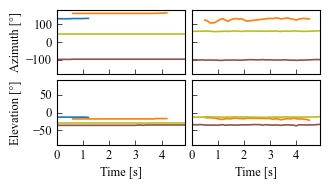

In [6]:
plot_frame_results(model, *(test_dataset[529][:2]))
